Covariance matrices estimated from observed return time series are often polluted by noise. When there are $k$ assets, we use the return data to estimate $k$ variance and $k \times (k - 1) / 2$ covariance values. The number of estimates is usually much larger than the number of observations. To help separate signal from noise in covariance matrix estimation, we can look into random matrix theory.

The notebook illustrates how we can apply a result in random matrix theory, the **Marchenko–Pastur law**, to denoise a covariance matrix. Empirical tests with S&P 500 constituent return data show denoised covariance matrix generates superior out-of-sample performance in portfolio optimization.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from scipy.optimize import minimize_scalar

%matplotlib inline
plt.style.use('seaborn')

The Marchenko–Pastur law describes the distribution of eigenvalues of a random matrix. For a $m \times n$ matrix $X$ whose entries are independent and identically distributed random variables with mean 0 and finite variance $\sigma^2$, the eigenvalues $\lambda$ of $$\frac{1}{m} XX^T$$
asymptotically follows the Marchenko–Pastur distribution. The probability density function $f$ of the eigenvalues is 
$$
q = {m}/{n},\ \lambda_{+} = \sigma^2 \left( 1 + \sqrt{1 / q}\right)^2,\ 
\lambda_{-} = \sigma^2 \left( 1 - \sqrt{1 / q}\right) ^2
\\~\\
f(\lambda) = \begin{cases}
                q \frac{\sqrt{(\lambda_{+} -\lambda)(\lambda-\lambda_{-})} }{2 \pi \lambda \sigma^2}, &  \lambda_{-} \leq \lambda \leq \lambda_{+} ,\\
                 0, & \text{otherwise}
                    \end{cases}
                     
$$

$\lambda_{+}$ and $\lambda_{-}$ are the maximum and minimum eigenvalues possible.
If $X$ is a data matrix where each row is an observation, it is easy to see that $\frac{1}{m} XX^T$ is the covariance matrix estimate.

In [2]:
def getEigenBound(var, q):
    # q: ratio of the  
    return (var * (1. - np.sqrt(1. / q)) ** 2, var * (1. + np.sqrt(1. / q)) ** 2)

def makeMpPdf(var, q):
    (min_eigenvalue, max_eigenvalue) = getEigenBound(var, q)
    tmp = q / (2 * np.pi * var)
    def pdfFun(x):
        result = np.zeros(x.shape)
        mask = (x > min_eigenvalue) & (x < max_eigenvalue)
        result[mask] = \
            tmp * np.sqrt((max_eigenvalue - x[mask]) * (x[mask] - min_eigenvalue)) / x[mask]
        return result
    return pdfFun

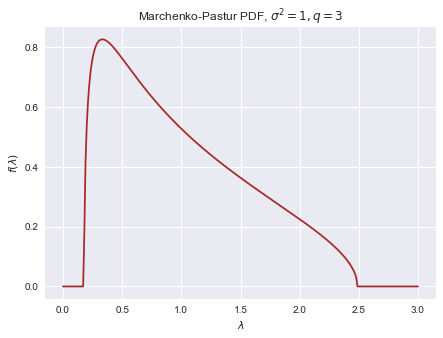

In [3]:
fig, ax = plt.subplots(1, 1, figsize=(7,5))
x = np.linspace(0, 3, 300)
ax.plot(x, makeMpPdf(1, 3)(x), color='brown')
ax.set(
    xlabel=r'$\lambda$', 
    ylabel=r'$f (\lambda )$',
    title=r'Marchenko-Pastur PDF, $\sigma^2=1, q=3 $'
);

How can the Marchenko–Pastur law be applied to stock returns? We first compute the correlation matrix from the daily returns of S&P 500 constituents and plot the distribution of its eigenvalues.

In [4]:
data = pd.read_csv('./fixtures/snp_rtn.csv').set_index('date')
data.index = pd.to_datetime(data.index)
print(f'S&P 500 constituents daily returns from {data.index[0]} to {data.index[-1]}')
print(f'Stocks excluded for missing data: {", ".join(data.columns[data.isna().any(axis=0)].values)}')
data = data.loc[:, ~data.isna().any(axis=0)]
tickers = data.columns[~data.isna().any(axis=0)].values

S&P 500 constituents daily returns from 2016-03-30 00:00:00 to 2022-03-30 00:00:00
Stocks excluded for missing data: CARR, CDAY, CEG, CTVA, DOW, FOX, FOXA, FTV, HWM, IR, LW, MRNA, OGN, OTIS


In [5]:
m = data.values.shape[0]
n = data.values.shape[1]
print(f'Dataset has {n} stocks and {m} days of return')
q = data.shape[0] / data.shape[1]
print(f'q = {round(q, 4)}')

Dataset has 491 stocks and 1513 days of return
q = 3.0815


In [6]:
pca = PCA()
pca.fit(data.values / np.std(data.values, axis=0));

The maximum eigenvalue is close to 200, which represents the market component. Most eigenvalues lie between 0 and 1 and have a similar shape as the Marchenko–Pastur distribution. This is inline with the hypothesis that stock returns contain random matrix noise that determines the distribution of the smaller eigenvalues.

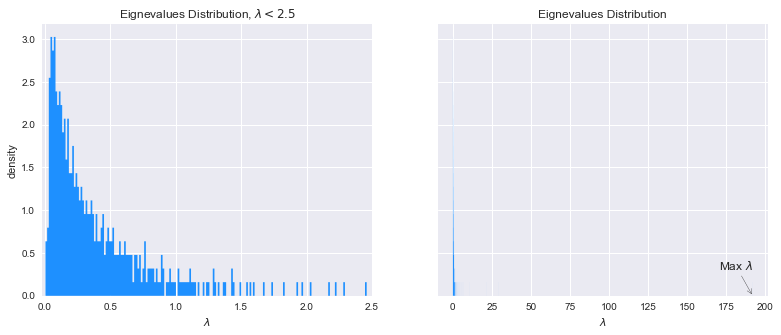

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(13,5),sharey=True)
ax[0].hist(pca.explained_variance_, density=True, bins=15000, histtype='stepfilled', color='dodgerblue')
ax[0].set(
    xlim=(-0.02, 2.5), 
    xlabel=r'$\lambda$', 
    ylabel='density', 
    title=r'Eignevalues Distribution, $\lambda < 2.5$'
)
ax[1].hist(pca.explained_variance_, density=True, bins=15000, histtype='stepfilled', color='dodgerblue')
ax[1].annotate( 
    r'Max $\lambda$', xy=(pca.explained_variance_[0], 0.0), 
    xytext=(pca.explained_variance_[0], 0.3),
    fontsize=12,
    horizontalalignment='right',
    arrowprops=dict(arrowstyle="->")
);
ax[1].set(xlabel=r'$\lambda$', title='Eignevalues Distribution');


As a correlation matrix is the covariance of standardized stock returns, we may assume that a portion of the variance $\sigma^2 < 1$ in the standardized stock returns is actually random noise. To know what  $\sigma^2$ is, we can adjust it to fit the Marchenko–Pastur distribution to the observed eigenvalues. We can assume that the eigenvalues greater than the fitted $\lambda_+$ contain informative signal, and those less than the fitted $\lambda_+$ are just random noise.

Here, $\sigma^2$ is fitted to the Marchenko–Pastur distribution by maximum likelihood estimation. 

There are other ways to fit $\sigma^2$. For example, this [book](https://www.cambridge.org/core/elements/abs/machine-learning-for-asset-managers/6D9211305EA2E425D33A9F38D0AE3545) suggests estimating $\sigma^2$ by fitting the kernel density of the observed eigenvalues to the Marchenko–Pastur PDF. A test not shown here indicates that both approaches give similar results. The maximum likelihood estimation is chosen here as it has fewer parameters to tune and is much faster.

In [8]:
def fitMpPdf(q, eigenvalues):
    def cost(var):
        return -np.sum(np.log(1e-9 + makeMpPdf(var, q)(eigenvalues))) # Add 1e-9 to avoid log(0)
    min_result = minimize_scalar(cost, bounds=(1e-9, 1), method='bounded', options={"xatol":0.005})
    return min_result.x

In [9]:
fitted_var = fitMpPdf(q, pca.explained_variance_)
print(f'{round(fitted_var * 100)}% \
of the variance in the standardized stock returns is just random matrix noise. \
{round(np.mean(pca.explained_variance_ < getEigenBound(fitted_var, q)[1]) * 100)}% \
of the eigenvalues can be considered as randomly drawn from the Marchenko–Pastur distribution.')

37% of the variance in the standardized stock returns is just random matrix noise. 87% of the eigenvalues can be considered as randomly drawn from the Marchenko–Pastur distribution.


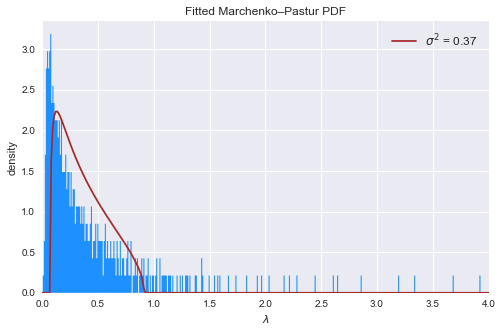

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(8,5))
x = np.linspace(0, 4, 300)
ax.plot(x, makeMpPdf(fitted_var, q)(x), color='brown', label=rf'$\sigma^2$ = {round(fitted_var, 2)}')
ax.hist(pca.explained_variance_, density=True, bins=20000, histtype='stepfilled', color='dodgerblue')
ax.set(
    xlim=(0, 4), 
    xlabel=r'$\lambda$', 
    ylabel='density', 
    title='Fitted Marchenko–Pastur PDF'
)
ax.legend(fontsize=12);

As the eigenvalues below $\lambda_+$ are drawn from the random distribution, they can be considered to be interchangeable. This suggests that it is possible to denoise the correlation matrix by replacing the eigenvalues below $\lambda_+$ with a constant. The mean of the eigenvalues below $\lambda_+$ is used to preserved the total variance. The denoised correlation matrix helps us avoid being fooled by the variation in the smaller eigenvalues in our analysis.

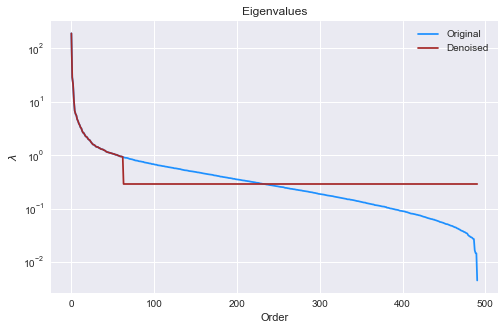

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(8,5))
x = np.linspace(0, 4, 300)
denoised_eigenvalues = np.copy(pca.explained_variance_)
denoised_eigenvalues[denoised_eigenvalues < getEigenBound(fitted_var, q)[1]] = \
  np.mean(denoised_eigenvalues[denoised_eigenvalues < getEigenBound(fitted_var, q)[1]])
ax.plot(pca.explained_variance_, label='Original', color='dodgerblue')
ax.plot(denoised_eigenvalues, label='Denoised', color='brown')
ax.legend()
ax.set_yscale('log')
ax.set(title='Eigenvalues', xlabel='Order', ylabel=r'$\lambda$');

We can reconstruct the covariance matrix from the denoised eigenvalues to obtain a denoised estimate of the covariance matrix.

In [12]:
def denoiseCov(rtn):
    q = rtn.shape[0] / rtn.shape[1]
    pca = PCA()
    vol = np.std(rtn, 0)
    pca.fit(rtn / vol)
    fitted_var = fitMpPdf(q, pca.explained_variance_)
    denoised_e = pca.explained_variance_
    e_upper = getEigenBound(fitted_var, q)[1]
    denoised_e[denoised_e < e_upper] = np.mean(denoised_e[denoised_e < e_upper])
    components = pca.components_ * np.sqrt(denoised_e)[:,np.newaxis]
    return np.matmul(components.T, components) * vol[:,None] * vol[None,:]

In [13]:
denoised_cov = denoiseCov(data.values)
cov = np.cov(data.values, rowvar=False)

One use of the covariance matrix is portfolio optimization. We compare the minimum variance weighting with shorting allowed with and without denoising. A simple regression of the weights with denoising on the original yields a slope of 0.4458, showing that denoising shrinks the minimum variance weights towards 0. The weights with denoising are less extreme as optimizing on noise is avoided. Less extreme weights should lead to better out-of-sample performance. More stable weights also imply lower portfolio turnover, an important consideration in real-world portfolio management.

In [14]:
def minVarAllocation(covar):
    w = np.linalg.solve(covar, np.ones(covar.shape[0]))
    w /= np.sum(w)
    return w

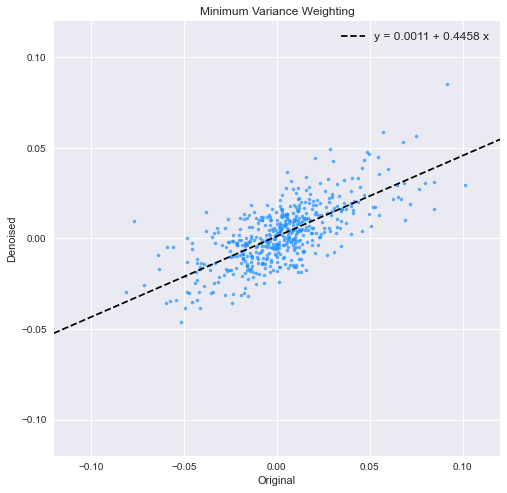

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(8,8))
original_weights = minVarAllocation(cov)
denoised_weights = minVarAllocation(denoised_cov)
reg_coef = np.polyfit(original_weights, denoised_weights, 1)
ax.plot(original_weights, denoised_weights, '.',color='dodgerblue', alpha=0.7)
ax.axline((0, reg_coef[1]), slope=reg_coef[0], color='k', linestyle='--',
 label=f'y = {round(reg_coef[1], 4)} + {round(reg_coef[0], 4)} x')
ax.legend(fontsize=12)
ax.set(xlim=(-0.12, 0.12),ylim=(-0.12, 0.12), 
    xlabel='Original', ylabel='Denoised', title='Minimum Variance Weighting');

We can use simulation to verify whether denoising improves the out-of-sample performance of minimum variance allocation. We first split the return data into two halves randomly. We can calculate the minimum variance weighting using the first half and check it with the second half, and vice versa. We then repeat the test 1000 times. 

We can compare minimum variance weighting with or without denoising according to:
1. Which is closer to the ideal minimum variance weighting if we know the out-of-sample return time series? We can measure it with the root mean square error of the in-sample weights with the ideal weights.
2. Which gives a lower out-of-sample portfolio volatility?
3. Which has a lower portfolio turnover? We measure it with the sum of absolute differences in weights.

In [16]:
# Split returns to test 
def splitTest(seed):
    rtn_1, rtn_2 = train_test_split(data.values, test_size=0.5, random_state=seed)
    denoised_cov_1 = denoiseCov(rtn_1)
    original_cov_1 = np.cov(rtn_1, rowvar=False)
    denoised_w_1 = minVarAllocation(denoised_cov_1)
    original_w_1 = minVarAllocation(original_cov_1)
    denoised_cov_2 = denoiseCov(rtn_2)
    original_cov_2 = np.cov(rtn_2, rowvar=False)
    denoised_w_2 = minVarAllocation(denoised_cov_2)
    original_w_2 = minVarAllocation(original_cov_2)

    original_err =   np.sqrt(np.mean((original_w_1 - original_w_2) ** 2))
    denoised_err_1 = np.sqrt(np.mean((denoised_w_1 - original_w_2) ** 2))
    denoised_err_2 = np.sqrt(np.mean((denoised_w_2 - original_w_1) ** 2))
    original_vol_1 = np.sqrt(np.inner(np.matmul(original_cov_2, original_w_1), original_w_1))
    denoised_vol_1 = np.sqrt(np.inner(np.matmul(original_cov_2, denoised_w_1), denoised_w_1))
    original_vol_2 = np.sqrt(np.inner(np.matmul(original_cov_1, original_w_2), original_w_2))
    denoised_vol_2 = np.sqrt(np.inner(np.matmul(original_cov_1, denoised_w_2), denoised_w_2))
    original_turnover = np.sum(np.absolute(original_w_1 - original_w_2))
    denoised_turnover = np.sum(np.absolute(denoised_w_1 - denoised_w_2))
    return (
        original_err,
        denoised_err_1,
        denoised_err_2,
        original_vol_1,
        denoised_vol_1,
        original_vol_2,
        denoised_vol_2,
        original_turnover,
        denoised_turnover
    )


In [17]:
np.random.seed(10)
test_result = pd.DataFrame.from_records([splitTest(np.random.randint(1000000)) for i in range(1000)], 
    columns =['original_err',
        'denoised_err_1',
        'denoised_err_2',
        'original_vol_1',
        'denoised_vol_1',
        'original_vol_2',
        'denoised_vol_2',
        'original_turnover',
        'denoised_turnover'])

The weighting with denoising is always closer to the ideal minimum variance weighting than that without denoising. The portfolios with denoising also have strictly lower out-of-sample volatility, reducing annualized volatility from 16% to 12% on average. In the worst case scenario, denoising reduces annualized volatility by around 2%. The denoised covariance matrix is clearly superior.

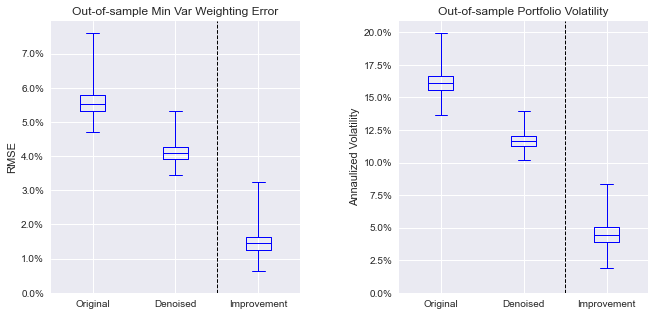

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(10.7,5))
fig.subplots_adjust(wspace=.4)

vis_data_rmse = np.concatenate([
        test_result[['original_err', 'denoised_err_1']].values, 
        test_result[['original_err', 'denoised_err_2']].values
])
vis_data_rmse = np.hstack([vis_data_rmse, vis_data_rmse[:,[0]] - vis_data_rmse[:, [1]]])
ax[0].boxplot(
    vis_data_rmse,
    whis=[0,100],
    boxprops=dict(color='blue'),
    capprops=dict(color='blue'),
    whiskerprops=dict(color='blue'),
    medianprops=dict(color='blue'),
)
ax[0].axvline(2.5, linestyle='--', color='black', linewidth=1)
ax[0].yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax[0].set(ylim=(0, None), ylabel='RMSE', title='Out-of-sample Min Var Weighting Error')
ax[0].set_xticklabels(['Original', 'Denoised', 'Improvement'])

vis_data_vol = np.concatenate([
        test_result[['original_vol_1', 'denoised_vol_1']].values, 
        test_result[['original_vol_2', 'denoised_vol_2']].values
])
vis_data_vol = np.sqrt(252) * np.hstack([vis_data_vol, vis_data_vol[:,[0]] - vis_data_vol[:, [1]]])
ax[1].boxplot(
    vis_data_vol, 
    whis=[0,100],
    boxprops=dict(color='blue'),
    capprops=dict(color='blue'),
    whiskerprops=dict(color='blue'),
    medianprops=dict(color='blue'),
)
ax[1].axvline(2.5, linestyle='--', color='black', linewidth=1)
ax[1].yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax[1].set(ylim=(0, None), ylabel='Annaulized Volatility', title='Out-of-sample Portfolio Volatility')
ax[1].set_xticklabels(['Original', 'Denoised', 'Improvement']);

Portfolio turnover with denoising is also strictly lower when applied to minimum variance weighting with shorting allowed. Denoising cuts the original portfolio turnover of 2000% by nearly three quarters on average. This again demonstrates the substantial benefit of denoising in real-world applications.

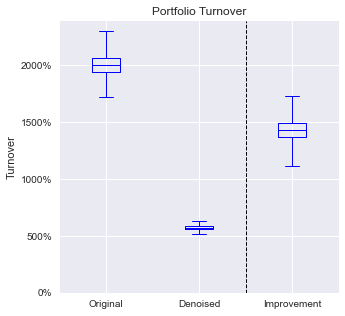

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(5,5))

vis_data_turnover = test_result[['original_turnover', 'denoised_turnover']].values
vis_data_turnover = np.hstack([vis_data_turnover, vis_data_turnover[:,[0]] - vis_data_turnover[:, [1]]])
ax.boxplot(
    vis_data_turnover,
    whis=[0,100],
    boxprops=dict(color='blue'),
    capprops=dict(color='blue'),
    whiskerprops=dict(color='blue'),
    medianprops=dict(color='blue'),
)
ax.axvline(2.5, linestyle='--', color='black', linewidth=1)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax.set(ylim=(0, None), ylabel='Turnover', title='Portfolio Turnover')
ax.set_xticklabels(['Original', 'Denoised', 'Improvement']);

Estimating a covariance matrix from observed return time series is difficult and the estimate is severely polluted by random noise. The experiment using empirical stock returns shows that random matrix theory can help us separate signal from noise in a covariance matrix. Denoising a covariance matrix diminishes the effect of noise and can be applied to improve out-of-sample performance in portfolio optimization.